In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torchvision import models, transforms
import torchvision
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd
import os
import glob
import cv2
from skimage.transform import resize
import matplotlib.pyplot as plt
%matplotlib inline
from unet import UNet
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from early_stopping import EarlyStopping

torch.manual_seed(1)
use_cuda = torch.cuda.is_available()
print("pytorch versino:", torch.__version__)
print("use cuda:", use_cuda)

submission_number = "010"

pytorch versino: 0.4.0
use cuda: True


## Load Images

In [2]:

base_dir = "/floyd/input/data"
#base_dir = "../salt_data"
test_image_dir = os.path.join(base_dir, "test")
train_dir = os.path.join(base_dir, "train")
train_image_dir = os.path.join(train_dir, "images")
train_mask_dir = os.path.join(train_dir, "masks")


In [3]:
def load_image(path):
    img = cv2.imread(path)
    img = img[:, :, 0:1] # take only 1 channel because every channel has same values
    img = np.transpose(img, (2, 0, 1))
    img = img / 255
    
    return img

In [4]:
train_df = pd.read_csv(os.path.join(base_dir, "train.csv"), index_col="id", usecols=[0])
depth_df = pd.read_csv(os.path.join(base_dir, "depths.csv"), index_col="id")
train_df = train_df.join(depth_df)
test_df = depth_df[~depth_df.index.isin(train_df.index)]

train_df.head()

,z
id,
575d24d81d,843
a266a2a9df,794
75efad62c1,468
34e51dba6a,727
4875705fb0,797


In [5]:
train_df["images"] = [load_image(os.path.join(train_image_dir, "%s.png" % x)).astype(np.float32) for x in train_df.index]
train_df["masks"] = [load_image(os.path.join(train_mask_dir, "%s.png" % x)).astype(np.float32) for x in train_df.index]
test_df["images"] = [load_image(os.path.join(test_image_dir, "%s.png" % x)).astype(np.float32) for x in test_df.index]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [6]:
len(test_df)

18000

### confirm the image and mask are gray scale

613


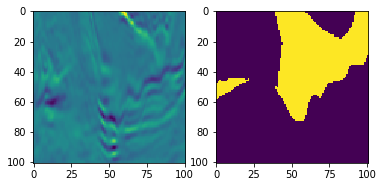

In [7]:
idx = 12
img = train_df["images"][idx]
mask = train_df["masks"][idx]



plt.subplot(1, 2, 1)
plt.imshow(img[0, :, :])

plt.subplot(1, 2, 2)
plt.imshow(mask[0, :, :])

print(train_df["z"][idx])

## coverage distribution

In [8]:
org_size = 101
train_df["coverage"] = train_df.masks.map(np.sum) / org_size**2

n_coverage_class = 21

def coverage_to_class(val):
    for i, x in enumerate(np.linspace(0, 1, n_coverage_class)):
        if val  <= x:
            return i
        

train_df["coverage_class"] = train_df.coverage.map(coverage_to_class)


In [9]:
train_df.head()

,z,images,masks,coverage,coverage_class
id,,,,,
575d24d81d,843,"[[[0.5254902, 0.5137255, 0.5254902, 0.5372549,...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",0.000000,0
a266a2a9df,794,"[[[0.34117648, 0.3764706, 0.33333334, 0.223529...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",0.504950,11
75efad62c1,468,"[[[0.5686275, 0.46666667, 0.3254902, 0.2627451...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",0.993334,20
34e51dba6a,727,"[[[0.5411765, 0.4745098, 0.39607844, 0.3058823...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",0.149201,3
4875705fb0,797,"[[[0.06666667, 0.078431375, 0.09019608, 0.1058...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",0.042839,1


(array([1562.,  421.,  155.,  171.,  125.,  105.,  119.,   94.,   92.,
         105.,  120.,   96.,  109.,   88.,   86.,   77.,   71.,   80.,
          79.,   82.,  163.]),
 array([ 0.        ,  0.95238095,  1.9047619 ,  2.85714286,  3.80952381,
         4.76190476,  5.71428571,  6.66666667,  7.61904762,  8.57142857,
         9.52380952, 10.47619048, 11.42857143, 12.38095238, 13.33333333,
        14.28571429, 15.23809524, 16.19047619, 17.14285714, 18.0952381 ,
        19.04761905, 20.        ]),
 <a list of 21 Patch objects>)

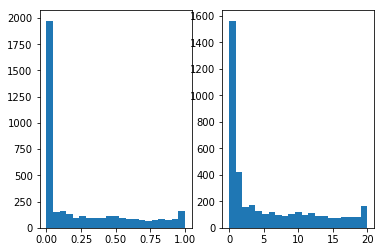

In [10]:
plt.subplot(1, 2, 1)
plt.hist(train_df.coverage, bins=21)
plt.subplot(1, 2, 2)
plt.hist(train_df.coverage_class, bins=n_coverage_class)

### depth vs coverage

### split training data based on coverage

In [11]:
train_id, valid_id = train_test_split(train_df.index.values, test_size=0.2, stratify=train_df.coverage_class, random_state=1)

valid_df = train_df.loc[train_df.index.isin(valid_id)]
train_df = train_df.loc[train_df.index.isin(train_id)]

In [12]:
org_train_df = train_df.copy()

### Training

In [13]:
class Resizing:
    def __init__(self, left, right, top, bottom):
        
        self.m = nn.ReflectionPad2d((left, right, top, bottom))
        
        # for slicing
        self.top = top
        self.bottom = -bottom if bottom != 0 else None # 0 not work in slice in unpad function
        self.left = left
        self.right = -right if right != 0 else None
        
    def pad(self, imgs):
        return self.m(imgs)
    
    def unpad(self, imgs):
        return imgs[:, :, self.top:self.bottom, self.left:self.right]

    
size_diff = 128 - 101
pad_size_left = size_diff // 2
pad_size_right = size_diff // 2 + size_diff % 2
pad_size_top = pad_size_left
pad_size_bottom = pad_size_right
print(pad_size_left, pad_size_right, pad_size_top, pad_size_bottom)

a = torch.arange(25).reshape(1,1,5,5)
rs = Resizing(0, 1, 0, 2)
b = rs.pad(a)
rs.unpad(b)


13 14 13 14


tensor([[[[  0.,   1.,   2.,   3.,   4.],
          [  5.,   6.,   7.,   8.,   9.],
          [ 10.,  11.,  12.,  13.,  14.],
          [ 15.,  16.,  17.,  18.,  19.],
          [ 20.,  21.,  22.,  23.,  24.]]]])

In [14]:
class SaltDataset(Dataset):
    def __init__(self, df, is_test=False):
        self.df = df
        self.is_test = is_test
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        
        img = self.df["images"][idx]
        
        if self.is_test:
            return img
        
        else:
            mask = self.df["masks"][idx]

            return img, mask
        
    
    

In [15]:
def train(model, device, data_loader, loss_fn, optimizer, pad_f):
    train_losses = []
    model.train()
    
    for i, (image, mask) in enumerate((data_loader)):
        image, mask = image.to(device), mask.to(device)
        image = pad_f(image)
        mask = pad_f(mask)
        
        y_pred = model(image)
        loss = loss_fn(y_pred, mask)
        train_losses.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
    
    return train_losses


def validation(model, device, data_loader, loss_fn, pad_f):
    val_losses = []
    model.eval()
    
    
    with torch.no_grad():
        for image, mask in data_loader:
            image, mask = image.to(device), mask.to(device)
            image = pad_f(image)
            mask = pad_f(mask)
            
            y_pred = model(image)

            loss = loss_fn(y_pred, mask)
            val_losses.append(loss.item())
    
    return val_losses

            

In [16]:
# data augmentation

#aug_df1 = train_df.copy()
#aug_df1["images"] = aug_df1.images.map(np.fliplr).map(np.copy) #np.copy needed to avoid negative stride
#aug_df1["masks"] = aug_df1.masks.map(np.fliplr).map(np.copy)

#aug2 = train_df.copy()
#aug2["images"] = train_df.images.map(np.flipud).map(np.copy)
#aug2["masks"] = train_df.masks.map(np.flipud).map(np.copy)



#train_df = pd.concat((train_df, aug_df1))
len(train_df)


3200

In [23]:
train_dataset = SaltDataset(train_df)
val_dataset = SaltDataset(valid_df)
train_data_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_data_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)

import unet
import importlib
importlib.reload(unet)
from unet import UNet


device = torch.device("cuda" if use_cuda else "cpu")
model = UNet(num_class=1, input_channel=1, depth=6, start_filters=16).to(device)

learning_rate = 1e-4
loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

n_epoch = 50

train_loss_list = []
val_loss_list = []

rs = Resizing(pad_size_left, pad_size_right, pad_size_top, pad_size_bottom)
es = EarlyStopping(patience=5)

Epoch: 0, Train: 0.430, Val: 0.453
Epoch: 1, Train: 0.376, Val: 0.381
Epoch: 2, Train: 0.351, Val: 0.354
Epoch: 3, Train: 0.388, Val: 0.328
Epoch: 4, Train: 0.371, Val: 0.302
Epoch: 5, Train: 0.244, Val: 0.280
Epoch: 6, Train: 0.270, Val: 0.247
Epoch: 7, Train: 0.227, Val: 0.224
Epoch: 8, Train: 0.156, Val: 0.217
Epoch: 9, Train: 0.186, Val: 0.216
Epoch: 10, Train: 0.252, Val: 0.203
Epoch: 11, Train: 0.134, Val: 0.193
Epoch: 12, Train: 0.133, Val: 0.186
Epoch: 13, Train: 0.153, Val: 0.187
Epoch: 14, Train: 0.085, Val: 0.188
Epoch: 15, Train: 0.067, Val: 0.179
Epoch: 16, Train: 0.086, Val: 0.182
Epoch: 17, Train: 0.121, Val: 0.183
Epoch: 18, Train: 0.128, Val: 0.195
Epoch: 19, Train: 0.117, Val: 0.206
Epoch: 20, Train: 0.063, Val: 0.193


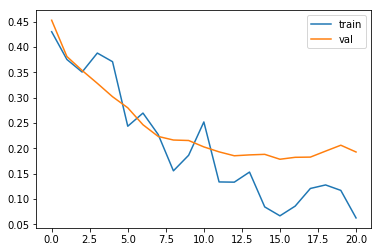

In [24]:
#n_epoch = 1

for epoch in range(n_epoch):
    
    train_losses = train(model, device, train_data_loader, loss_fn, optimizer, rs.pad)
    train_loss = np.mean(train_losses[-3])
    train_loss_list.append(train_loss)
    
    val_loss = np.mean(validation(model, device, val_data_loader, loss_fn, rs.pad))
    val_loss_list.append(val_loss)
    
    print("Epoch: %d, Train: %.3f, Val: %.3f" % (epoch, train_loss, val_loss))
    if es.step(val_loss, model, "model_%s" % submission_number):
        break

plt.plot(train_loss_list, label="train")
plt.plot(val_loss_list, label="val")
plt.legend()
        

In [ ]:
#torch.save(model.state_dict(), "model_%s" % submission_number)

### submission

In [25]:
#model.load_state_dict(torch.load("model_007"))

In [26]:
def rl_enc(img, order='F'):
    """Convert binary mask image to run-length array or string.
    
    Args:
    img: image in shape [n, m]
    order: is down-then-right, i.e. Fortran(F)
    string: return in string or array

    Return:
    run-length as a string: <start[1s] length[1s] ... ...>
    """
    bytez = img.reshape(img.shape[0] * img.shape[1], order=order)
    bytez = np.concatenate([[0], bytez, [0]])
    runs = np.where(bytez[1:] != bytez[:-1])[0] + 1 # pos start at 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

# Use for sanity check the encode function
def rl_dec(rl_string, shape=(101, 101), order='F'):
    """Convert run-length string to binary mask image.
    
    Args:
    rl_string: 
    shape: target shape of array
    order: decode order is down-then-right, i.e. Fortran(F)

    Return:
    binary mask image as array
    """
    s = rl_string.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape, order=order)

In [30]:


def test(model, device, data_loader, threshold, pad_f, unpad_f):
    model.eval()
    
    y_pred_all = []
    
    with torch.no_grad():
        
        for img in tqdm(data_loader):
            img = img.to(device)
            img = pad_f(img)
            
            y_pred = model(img)
            
            y_pred = unpad_f(y_pred)
            
            y_pred[y_pred >= threshold] = 1
            y_pred[y_pred < threshold] = 0
            
            y_pred_all.append(y_pred)
            
    
    
    y_pred_all = torch.cat(y_pred_all)
    y_pred_all = torch.squeeze(y_pred_all)
    
    return y_pred_all

def compute_iou(y_pred, y_true):
    intersection = np.sum(y_pred * y_true)
    union = np.sum((y_pred + y_true) > 0)
    
    return max(intersection, 1e-9) / max(1e-9, union)


def compute_mean_iou(y_preds, y_trues):
    return np.mean([compute_iou(y_pred, y_true) for y_pred, y_true in zip(y_preds, y_trues)])


def return_predicts_and_trues(model, device, data_loader, pad_f, unpad_f):
    """returns original size(nx101x101), not padded size(nx128x128), where n is # of data.
    """
    y_pred_all = []
    y_true_all = []
    model.eval()
    
    with torch.no_grad():
        for image, mask in data_loader:
            image, mask = image.to(device), mask.to(device)
            image = pad_f(image)
            
            y_pred = model(image)
            y_pred = unpad_f(y_pred)
            
            y_pred_all.append(y_pred)
            y_true_all.append(mask)
    
    
    y_pred_all = torch.cat(y_pred_all)
    y_pred_all = torch.squeeze(y_pred_all)
    
    y_true_all = torch.cat(y_true_all)
    y_true_all = torch.squeeze(y_true_all)

    return y_pred_all, y_true_all


def threshold_predictions(y_pred, threshold):
    ret = y_pred.clone()
    ret[y_pred >= threshold] = 1
    ret[y_pred < threshold] = 0

    return ret
    


### determin best threshold from validation set

0.76


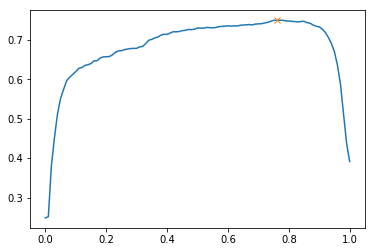

In [31]:
thresholds = np.linspace(0., 1, 101)

y_preds, y_trues = return_predicts_and_trues(model, device, val_data_loader, rs.pad, rs.unpad)
mean_ious = []
for th in thresholds:
    mask = threshold_predictions(y_preds, th)
    mean_ious.append(compute_mean_iou(mask.cpu().numpy(), y_trues.cpu().numpy()))

max_th_index = np.argmax(mean_ious)
max_threshold = thresholds[max_th_index]
max_iou = mean_ious[max_th_index]
plt.plot(thresholds, mean_ious)
plt.plot([max_threshold], [max_iou], 'x')
print(max_threshold, )

In [ ]:

test_dataset = SaltDataset(test_df, is_test=True)
test_data_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)
y_pred_all = test(model, device, test_data_loader, max_threshold, rs.pad, rs.unpad)

masks_all = y_pred_all.cpu().numpy()
#np.save("masks_all.npy", masks_all)


 83%|████████▎ | 59/71 [00:34<00:07,  1.71it/s]

In [ ]:
#masks_all = np.load("masks_all.npy")

In [ ]:
with open("submission_%s.csv" % submission_number, 'w') as f:
    f.write("id,rle_mask\n")
    for idx, mask in tqdm(zip(test_df.index, masks_all)):
        f.write("%s,%s\n" % (idx, rl_enc(mask)))